# Part A: Gaussian Generative Classifier

## Overview
This notebook implements and evaluates a **Gaussian Generative Classifier** for the Handwritten Digits dataset.

## Objectives 
1. **Implementation**: Verify the generative model using shared covariance .
2. **Hyperparameter Tuning**: Optimize the regularization term $\lambda$ .
3. **Performance Evaluation**: Report accuracy, macro-precision/recall/F1, and confusion matrix .
4. **Analysis**: Discuss confusion patterns and the effect of regularization.

## Mathematical Foundation
We model the class-conditional density $P(x|y=k)$ as a multivariate Gaussian $\mathcal{N}(\mu_k, \Sigma)$.
* **Assumption**: All classes share the same covariance matrix $\Sigma$.
* **Regularization**: To ensure stability, we use $\Sigma_\lambda = \Sigma + \lambda I$.
* **Decision Rule**: Maximize the log-posterior:
$$\text{score}_k = \log \pi_k - \frac{1}{2}(x - \mu_k)^T \Sigma_\lambda^{-1} (x - \mu_k)$$


## 1. Setup and Data Loading

In [3]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.data_loader import load_and_split_data
from src.utils import metrics
from src.utils import plots

X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data()

print(f"Data Loaded Successfully:")
print(f"Training Shape: {X_train.shape}")
print(f"Validation Shape: {X_val.shape}")
print(f"Test Shape: {X_test.shape}")

Data Loaded Successfully:
Training Shape: (1257, 64)
Validation Shape: (270, 64)
Test Shape: (270, 64)


## 2. Model Implementation


In [4]:
from src.models import gaussian_generative
importlib.reload(gaussian_generative)

from src.models.gaussian_generative import GaussianGenerativeClassifier

print("GaussianGenerativeClassifier imported successfully.")

GaussianGenerativeClassifier imported successfully.


## 3. Hyperparameter Tuning
We tune the covariance regularization parameter $\lambda$
* **Candidates**: $\{ 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1.0 \}$

In [5]:
from sklearn.metrics import accuracy_score

candidates = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]
tuning_results = []
best_acc = -1
best_lambda = None

print(f"{'Lambda':<10} | {'Train Acc':<10} | {'Val Acc':<10}")
print("-" * 40)

for lam in candidates:
    model = GaussianGenerativeClassifier(regularization=lam)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    
    tuning_results.append({
        'lambda': lam,
        'train_accuracy': train_acc,
        'validation_accuracy': val_acc
    })
    
    print(f"{lam:<10} | {train_acc:.4f}     | {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_lambda = lam

print("-" * 40)
print(f"Best Lambda: {best_lambda} with Validation Accuracy: {best_acc:.4f}")

Lambda     | Train Acc  | Val Acc   
----------------------------------------
0.0001     | 0.9690     | 0.9444
0.001      | 0.9690     | 0.9444
0.01       | 0.9682     | 0.9444
0.1        | 0.9642     | 0.9444
1.0        | 0.9475     | 0.9222
----------------------------------------
Best Lambda: 0.0001 with Validation Accuracy: 0.9444


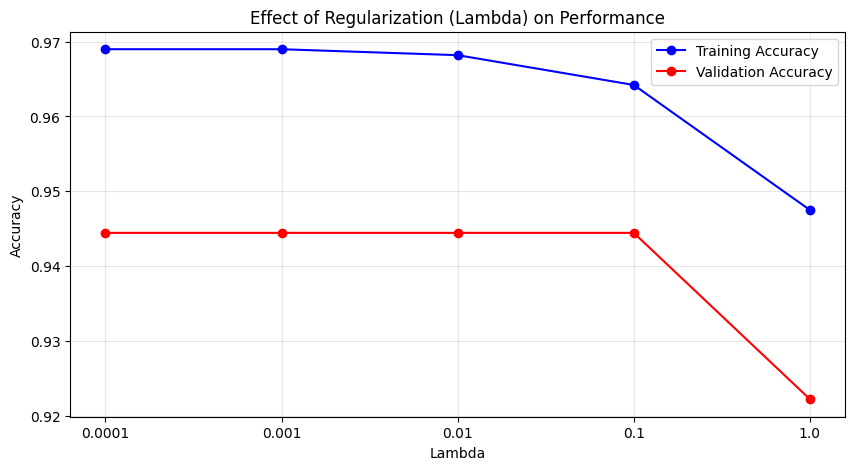

In [7]:
# Visualize Tuning Results
df_tuning = pd.DataFrame(tuning_results)

plt.figure(figsize=(10, 5))
plt.plot(df_tuning['lambda'].astype(str), df_tuning['train_accuracy'], 'b-o', label='Training Accuracy')
plt.plot(df_tuning['lambda'].astype(str), df_tuning['validation_accuracy'], 'r-o', label='Validation Accuracy')

plt.title("Effect of Regularization (Lambda) on Performance")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Final Evaluation and Testing

We retrain the model on the combined **Training + Validation** set using the optimal $\lambda$, then evaluate on the **Test Set**.

Retraining final model with Lambda = 0.0001...

=== Final Test Set Performance (Lambda=0.0001) ===


Accuracy,Precision,Recall,F1_score
96.30%,96.32%,96.27%,96.25%


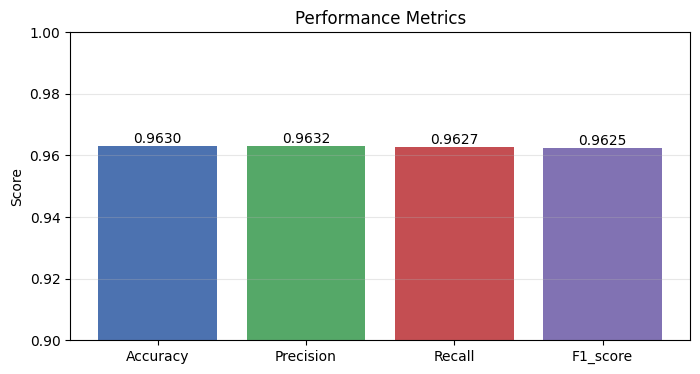

In [20]:
X_combined = np.vstack((X_train, X_val))
y_combined = np.hstack((y_train, y_val))

print(f"Retraining final model with Lambda = {best_lambda}...")
final_model = GaussianGenerativeClassifier(regularization=best_lambda)
final_model.fit(X_combined, y_combined)

y_test_pred = final_model.predict(X_test)
from src.utils.metrics import calculate_metrics_macro
test_metrics = calculate_metrics_macro(y_test, y_test_pred, label='Test ')

print(f"\n=== Final Test Set Performance (Lambda={best_lambda}) ===")

metrics_df = pd.DataFrame([test_metrics])

metrics_df.columns = [col.replace('Test ', '').capitalize() for col in metrics_df.columns]

display(metrics_df.style.format("{:.2%}").hide(axis='index'))

plt.figure(figsize=(8, 4))
bars = plt.bar(metrics_df.columns, metrics_df.iloc[0], color=['#4c72b0', '#55a868', '#c44e52', '#8172b3'])
plt.ylim(0.9, 1.0) 
plt.title("Performance Metrics")
plt.ylabel("Score")
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom')
plt.show()

## 5. Confusion Matrix Analysis

Confusion Matrix (Lambda=0.0001)


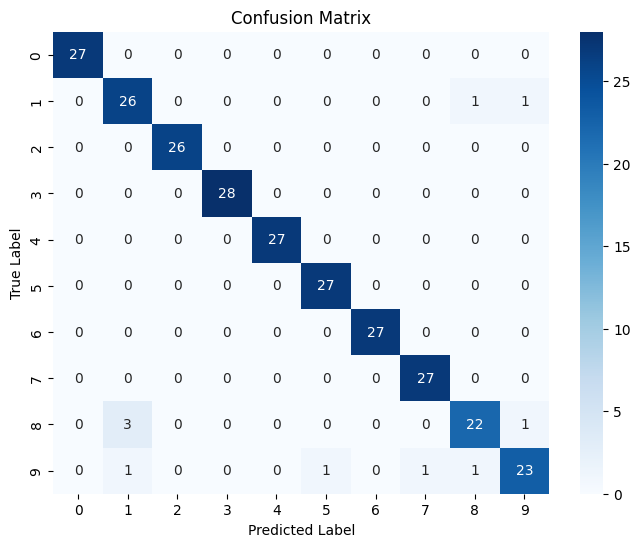

In [15]:
from src.utils.plots import plot_confusion_matrix

print(f"Confusion Matrix (Lambda={best_lambda})")

classes = [str(c) for c in final_model.classes]
_ = plot_confusion_matrix(y_test, y_test_pred, classes=classes)

## 6. Comparison with Builtin Scikit-Learn
To verify the correctness of our implementation, we compare it against `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`.
* Our Gaussian model with **Shared Covariance** is theoretically equivalent to LDA.
* Small differences are expected due to how regularization ($\lambda$) is applied versus Scikit-Learn's internal solvers.

=== Comparison with Scikit-Learn LDA ===


Metric,Custom Model,Scikit-Learn LDA
Accuracy,96.30%,96.30%


Confusion Matrix (Scikit-Learn):


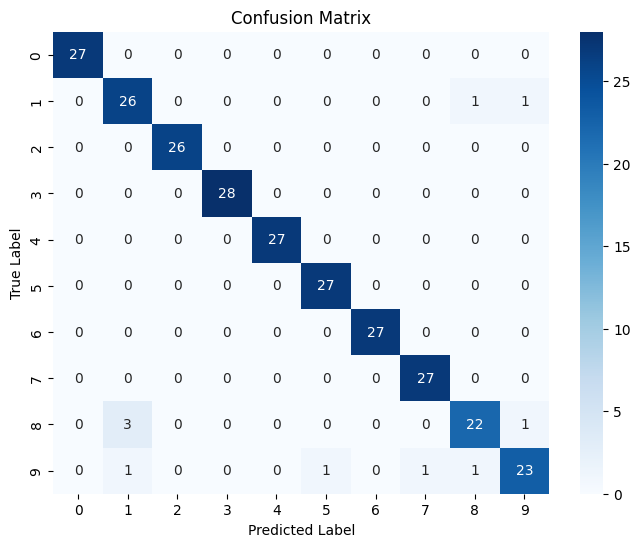

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from src.utils.plots import plot_confusion_matrix

print("=== Comparison with Scikit-Learn LDA ===")

lda_sk = LinearDiscriminantAnalysis()
lda_sk.fit(X_combined, y_combined)
y_pred_sk = lda_sk.predict(X_test)

acc_custom = metrics_df.iloc[0]['Accuracy'] 
acc_sklearn = accuracy_score(y_test, y_pred_sk)

comparison_df = pd.DataFrame({
    "Metric": ["Accuracy"],
    "Custom Model": [acc_custom],
    "Scikit-Learn LDA": [acc_sklearn]
})

display(comparison_df.style.format({
    "Custom Model": "{:.2%}",
    "Scikit-Learn LDA": "{:.2%}"
}).hide(axis='index'))

print("Confusion Matrix (Scikit-Learn):")
classes = [str(c) for c in lda_sk.classes_]

_ = plot_confusion_matrix(y_test, y_pred_sk, classes=classes)

## 7. Discussion and Analysis

#### Confusion & Errors:
 The model distinguishes most digit classes well, as shown by the strong diagonal on the confusion matrix. Most errors occurred between visually similar digits with overlapping stroke patterns, such as 6 vs 1, 4 vs 8, and 5 vs 8.

#### Effect of Regularization ($\lambda$):
Small values of $\lambda$ ($10^{-4}$ to $10^{-2}$) provided stable, high accuracy (~94.4%), in contrast a large $\lambda$ ($1.0$) caused a significant drop in performance by oversmoothing the covariance matrix.

#### Strengths & Weaknesses:
 While computationally efficient and accurate on structured data like digits, the model's restrictive shared covariance assumption limits its ability to capture complex variations. This makes it less effective than flexible discriminative models when handling non-linear data distributions.